<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/confirm_label_noize_for_cm_data/eras/confirm_label/clean_and_make_CM_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 id=title>このコードの意図：</h1>
  <p id=content>収集したCM（生データ）を加工情報を使って加工し、ニューラルネットの学習で使用できるように整形データとすること </p>

<h1 id=relations>関連：</h1>
  <ul>
    <li><h2>生データ</h2></li>
    <li><h2>整形データ</h2></li>
    <li><h2>加工情報</h2></li>
  </ul>

<table>
  <tr><th>変更日時（降順）</th> <th>変更者</th></tr>
  <tr><td>2021/01/29</td><td>森谷亮太</td>
</table>



# 環境設定

<h2>生データ</h2>
<ul>
  <li>入力される生データは特定のパス（dataPath)にファイルとして存在する。</li>
  <li>生データはラベルによってクラス毎のディレクトリで振り分けられている。（前のプロセス/first_process）</li>

</ul>

In [8]:
dataPath = "/content/drive/MyDrive/original_CM_data" # Need to access to certain gdrive account.
CLASSES = ["0.other", "1.food", "2.car", "3.cosme"] # Designed already.

<h2>出力フォーマット</h2>
<ul>
  <li>整形データの出力先は特定のパス(outPath)に定められている。</li>
  <li>整形データは1次元となったnumpy形式のビデオを複数含む配列となり、npz形式で保存される。</li>
  <li>整形データ、ラベルデータ、可視化したグラフは以下のようなファイル名で保存される。ファイル名には処理をした日付が含まれる。</li>

</ul>

In [9]:
outPath = "/content/drive/MyDrive/colab/CM_source/cleaned_CM" # Need to access to certain gdrive account.

In [28]:
Label_npz_pattern = r"Label(\d{4})\.npz"
Data_npz_pattern = r"Data(\d{4})\.npz"
Summary_image_pattern = r"summary_CM_data(\d{4})\.png"

<h2>加工情報</h2>
<ul>
  <li>整形されたビデオ１つは以下のように表現される。</li>
  <li>フレームの高さ, 幅, 枚数, 色情報がそれぞれ、45, 80, 30, RGB で定められたもの。</li>
  <li>実際的には以上の４次元で表されたものが、引き延ばされ１次元で表されたもの。</li>


</ul>

In [11]:
class video_format:
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"

#実行

In [20]:
#@title import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process dealing
import gc

# other
import re
import requests
import datetime

now_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
today = now_time.strftime('%m%d')

## パス接続

In [14]:
def connect_to_gdrive():
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  else:
    print("Already confirm")

def create_and_connect_to_desk():
  desk = '/content/desk'
  if not os.path.exists(desk):
    os.mkdir(desk)
  print("Created at /content/desk")
  return desk


In [15]:
connect_to_gdrive()
desk = create_and_connect_to_desk()

Mounted at /content/drive
Created at /content/desk


##データ確認

exist the path.
clean the class :  0.other
|------------- exist the path :  /content/drive/MyDrive/original_CM_data/0.other
____|------------ exist 35 files in the class
____|------------ accumulated is 35
clean the class :  1.food
|------------- exist the path :  /content/drive/MyDrive/original_CM_data/1.food
____|------------ exist 0 files in the class
____|------------ accumulated is 35
clean the class :  2.car
|------------- exist the path :  /content/drive/MyDrive/original_CM_data/2.car
____|------------ exist 0 files in the class
____|------------ accumulated is 35
clean the class :  3.cosme
|------------- exist the path :  /content/drive/MyDrive/original_CM_data/3.cosme
____|------------ exist 0 files in the class
____|------------ accumulated is 35


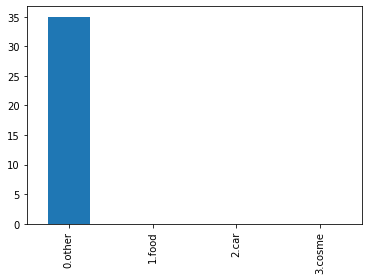

In [16]:
if os.path.isdir(dataPath):
  print("exist the path.")

  accumulated_value_for_cleaned_data = []

  # into each class
  for each_class in CLASSES:
    print("clean the class : ", each_class)
    each_class_path = path.join(dataPath, each_class)
    if os.path.isdir(each_class_path):
      print("|------------- exist the path : ", each_class_path)
      files_in_each_class = os.listdir(each_class_path)
      size_of_each_class = len(files_in_each_class)
      accumulated_value_for_cleaned_data.append(size_of_each_class)
      print("____|------------ exist", size_of_each_class, "files in the class")
      print("____|------------ accumulated is", sum(accumulated_value_for_cleaned_data))

    else:
      print("error")
      exit(0)
    print("===========================================================================")
  
  # plot and save original data
  fig, axes = plt.subplots(1, 1)
  data = pd.Series(accumulated_value_for_cleaned_data, index=CLASSES)
  data.plot.bar()

  plt.show()


else:
  print("no such path.")


##データ取込・整形

In [17]:
import math
import cv2
def makeupVideo(video_path, debug=False):
  format1=video_format()
  video = cv2.VideoCapture(video_path)
  framesize = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  cutTiming = math.floor(framesize / format1.FRAME_SIZE)
  cutTail = cutTiming * format1.FRAME_SIZE
  normalizedFrames = []
  count = 0
  while count <= cutTail - 1:
    IO, frame = video.read()
    if (count % cutTiming) == 0: 
      if not IO:
        print("error") 
        send_line_notify("error")
        return False, False, False

      else: 
        fixedFrame = cv2.resize(frame, dsize=(format1.WIDTH, format1.HEIGHT))
        check(fixedFrame, debug)
        fixedFrame = fixedFrame.flatten().astype(np.float32)/255.0
        normalizedFrames.append(fixedFrame)
    else:
      pass
    count += 1

  normalizedFrames = np.array(normalizedFrames)
  normalizedFrames = normalizedFrames.flatten()
  return True, normalizedFrames, framesize

def check(image, debug):
  if debug == True:
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
  else:
    return

In [18]:
%%time
# into each class
debug = False
cleaned_data_contener = []
label_contener = []
frame_sizes = []
for counter_class, each_class in enumerate(CLASSES):
  print("clean the files in the class : ", each_class)
  each_class_path = path.join(dataPath, each_class)
  if os.path.isdir(each_class_path):
    print("|------------- the path : ", each_class_path)
    files_in_each_class = os.listdir(each_class_path)
    size_of_each_class = len(files_in_each_class)
    # into each file
    for each_file in files_in_each_class:
      if re.match(r".*\..*", each_file,):
        print("________|------------ start to clean: ", each_file)
        each_file_path = path.join(each_class_path, each_file)
        if path.exists(each_file_path):
          print("________________|------------- confirm the file.")
          IO, cleaned_data, frame_size = makeupVideo(each_file_path, False)
          if IO:
            print("________________|------------- the frame size:", frame_size)
            cleaned_data_contener.append(cleaned_data)
            frame_sizes.append(frame_size)
            label_contener.append(counter_class)
            print("________________|------------- finish the treatment.")
          else:
            accumulated_value_for_cleaned_data[counter_class] -= 1
            print("________________|------------- skip by the file broken")
        else:
          print("________________|------------- can not confirm the file.")
          exit(0)
      else:
        print("________|------------ ignore the system file")
      # break
  else:
    exit(0)
print("===========================================================================")

print("finish all")
#/for


clean the files in the class :  0.other
|------------- the path :  /content/drive/MyDrive/original_CM_data/0.other
________|------------ start to clean:  au_Wallet_30秒.mpg
________________|------------- confirm the file.
________________|------------- the frame size: 899
________________|------------- finish the treatment.
________|------------ start to clean:  Yamato_宅急便コンパクト.mpg
________________|------------- confirm the file.
________________|------------- the frame size: 899
________________|------------- finish the treatment.
________|------------ start to clean:  住友生命_未来デザイン1UP.mp4
________________|------------- confirm the file.
________________|------------- the frame size: 899
________________|------------- finish the treatment.
________|------------ start to clean:  ニトリ_わんぱく組.mp4
________________|------------- confirm the file.
________________|------------- the frame size: 450
________________|------------- finish the treatment.
________|------------ start to clean:  ソフラ

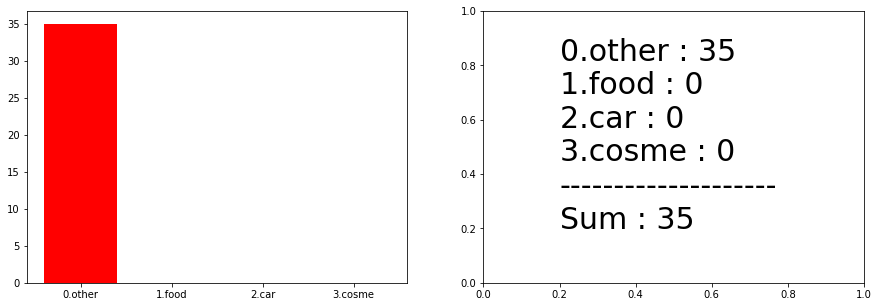

In [21]:
def sentence():
  sentence = ""
  sum = 0
  for i, each_class in enumerate(CLASSES):
    sum += accumulated_value_for_cleaned_data[i]
    sentence += str(each_class) + " : "
    sentence += str(accumulated_value_for_cleaned_data[i]) + "\n"
  
  sentence += "--------------------\n"
  sentence += "Sum : " + str(sum)

  return sentence



HEIGHT = 1
WIDTH = 2
rate = 5.0
WpH_rate = 1.5
fig = plt.figure(figsize=(WIDTH*rate*WpH_rate, HEIGHT*rate))
# plot of main
main = fig.add_subplot(HEIGHT, WIDTH, 1) 
COLOR_SET = ['red', 'blue', 'green', 'black']
main.bar(CLASSES, accumulated_value_for_cleaned_data, color=COLOR_SET)
# plot of memo
memo = fig.add_subplot(HEIGHT, WIDTH, 2) 

sentence = sentence()

memo.text(0.2, 0.2, sentence, size=30)

# save
save_name = "summary_CM_data"
save_name += today
save_name += ".png"

plt.savefig(path.join(desk, save_name))
plt.show()

# データ出力

In [24]:
def save_data(set_of_npdata, saveName):
  np.savez(os.path.join(desk, saveName), *set_of_npdata)

if len(cleaned_data_contener) == len(label_contener):
  save_data(cleaned_data_contener, "Data"+today)
  save_data(label_contener, "Label"+today)

In [32]:
want_objects = []
for each in os.listdir(desk):
  if re.match(Label_npz_pattern, each) or re.match(Data_npz_pattern, each) or re.match(Summary_image_pattern, each):
    print(each, "is appended.")
    want_objects.append(each)
  else:
    pass

summary_CM_data0129.png is appended.
Label0129.npz is appended.
Data0129.npz is appended.


In [47]:
if os.path.exists(outPath):
  for each in os.listdir(outPath):
    if re.match(Label_npz_pattern, each) or re.match(Data_npz_pattern, each) or re.match(Summary_image_pattern, each):
      print("exist already. so fix any:")
      print(os.listdir(outPath))
      print("update? Y/n")
      jud = input()
      if jud == 'Y':
        shutil.rmtree(outPath)
        os.mkdir(outPath)
      else:
        print("Done")
        break

else:
  os.mkdir(outPath)

In [48]:
for each in want_objects:
  shutil.copy2(
      os.path.join(desk, each),
      outPath
  )